## 국민건강보험 건강검진 정보는?

* 건강검진정보란 국민건강보험의 직장가입자와 40세 이상의 피부양자, 세대주인 지역가입자와 40세 이상의 지역가입자의 일반건강검진 결과와 이들 일반건강검진 대상자 중에 만40세와 만66세에 도달한 이들이 받게 되는 생애전환기건강진단 수검이력이 있는 각 연도별 수진자 100만 명에 대한 기본정보(성, 연령대, 시도코드 등)와 검진내역(신장, 체중, 총콜레스테롤, 혈색소 등)으로 구성된 개방데이터 중 만개의 데이터를 임의로 추출했습니다.

## EDA
* EDA는 [부스트코스] 파이썬으로 시작하는 데이터 사이언스 > 4. 건강검진 데이터로 가설검정하기 를 참고해 주세요.
https://www.edwith.org/boostcourse-ds-510/lectures/28143

## 분류 모델로 음주여부 예측하기

* 건강검진 센터에서 음주여부에 응답을 하지 않는 사람이 있다고 가정합니다.
* 검진 데이터를 바탕으로 음주여부를 예측한다면 건강한 생활습관을 가이드하는데 도움이 될 것 입니다.
* 분류기 모델을 사용해서 건강검진 데이터를 바탕으로 음주여부를 예측해 봅니다.



## 필요한 라이브러리 로드
* 영상과 프로젝트 코드 작성에 사용한 버전입니다.
    * pandas : 1.0.1
    * numpy : 1.18.1
    * scikit-learn(sklearn) : 0.22.1

In [1]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy
# 시각화를 위한 seaborn, matplotlib.pyplot 을 로드합니다. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## 셀프리뷰를 위한 파일 로드

In [2]:
# classification_checker.py 를 import 해서 사용합니다.
# classification_checker 명칭을 줄여서 checker 라고 사용합니다.
import check_util.classification_checker as checker

In [3]:
# 셀프리뷰 파일이 정상로드 되었는지 확인합니다.
checker.check_load_self_review()

셀프리뷰 파일이 정상로드 되었습니다. 이어서 진행하셔도 좋습니다.


,subject,criteria,content,flag
todo,,,,
1,데이터 전처리,결측치 채우기,"""요단백""의 결측치를 최빈값으로 대체한다.",False
2,데이터 전처리,결측치 채우기,"""LDL콜레스테롤""의 결측치를 중앙값으로 대체한다.",False
3,데이터 전처리,결측치 확인,전체 데이터에 결측치가 있는지 확인한다.,False
4,데이터셋 분리,데이터셋 분리,"train, test 가 8:2로 되도록 분리한다.",False
5,모델 만들기,모델 만들기,RandomForestClassifier 모델을 정의한다.,False
6,모델의 성능 측정하기,Accuracy를 통한 성능 측정,사이킷런의 accuracy_score 를 통해 테스트 데이터 예측의 정확도가 72 ...,False


## 한글폰트 사용하기

In [4]:
# 한글폰트를 설정해 주지 않으면 그래프 상에서 한글이 깨져보입니다.
# 한글이 출력될 수 있도록 폰트 설정을 해줍니다.
# 운영체제별 설정을 위해 로드 합니다.
import os

# 윈도우, 맥 외의 OS는 별도로 설정해 주세요.
if os.name == 'posix':
    plt.rc("font", family="AppleGothic")
else:
    plt.rc("font", family="Malgun Gothic")
# 마이너스 폰트 깨지는 문제에 대한 대처
plt.rc("axes", unicode_minus=False)

In [5]:
# 레티나 설정을 해주면 글씨가 좀 더 선명하게 보입니다.
# 폰트의 주변이 흐릿하게 보이는 것을 방지합니다.
%config InlineBackend.figure_format = 'retina'

## 데이터 불러오기

In [6]:
df = pd.read_csv("data/health.csv")
df.shape

(10000, 34)

## EDA 

In [7]:
df["음주여부"].value_counts()

1.0    5037
0.0    4963
Name: 음주여부, dtype: int64

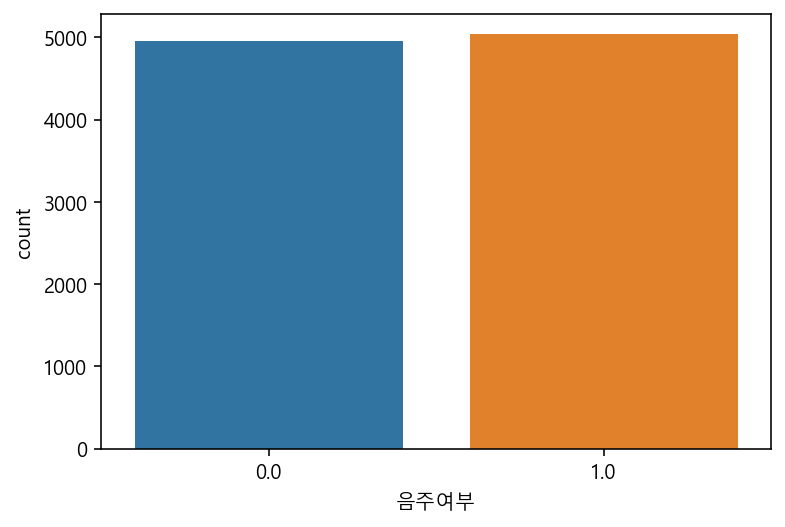

In [8]:
sns.countplot(data=df, x="음주여부")

## 데이터 전처리
### 결측치 여부 보기

In [9]:
df.isnull().sum()

기준년도                0
가입자일련번호             0
성별코드                0
연령대코드(5세단위)         0
시도코드                0
신장(5Cm단위)           1
체중(5Kg 단위)          1
허리둘레                0
시력(좌)               3
시력(우)               3
청력(좌)               1
청력(우)               1
수축기혈압               0
이완기혈압               0
식전혈당(공복혈당)          0
총콜레스테롤              0
트리글리세라이드            0
HDL콜레스테롤            0
LDL콜레스테롤           27
혈색소                 0
요단백                38
혈청크레아티닌             0
(혈청지오티)AST          0
(혈청지오티)ALT          0
감마지티피               0
흡연상태                1
음주여부                0
구강검진 수검여부           0
치아우식증유무         10000
결손치유무           10000
치아마모증유무         10000
제3대구치(사랑니)이상    10000
치석               6059
데이터공개일자             0
dtype: int64

### 결측치 채우기
* 결측치가 있다면 머신러닝 알고리즘이 학습과 예측을 할 수 없습니다.
* 결측치를 대체하는 방법으로는 여러가지가 있습니다. 평균, 중앙, 최빈값 등으로 채우기도 하며
* 그룹화된 값으로 대표값을 찾아 대체해 주기도 합니다.
* 결측치가 일부라면 제거하기도 합니다. 
* 또, 머신러닝을 통해 예측해서 대체하기도 합니다.

In [10]:
# 요단백의 빈도수를 세어봅니다.
df["요단백"].value_counts()

1.0    9391
2.0     304
3.0     170
4.0      70
5.0      19
6.0       8
Name: 요단백, dtype: int64

### <font color="red">TODO 1</font> 결측치를 최빈값으로 채우기
* <font color="blue">fillna</font>를 사용해서 요단백의 결측치를 <font color="red">최빈값</font>으로 채웁니다.

In [11]:
# 요단백의 최빈값을 구해서 mode 라는 변수에 할당합니다.
mode = df["요단백"].mode()[0]
mode

1.0

In [12]:
# 결측치를 채워주세요.
df["요단백"] = df['요단백'].fillna(mode) # 밑줄을 제거하고 코드를 작성해 주세요!

In [13]:
# 결측치가 제대로 채워졌는지 확인합니다.
df["요단백"].isnull().sum()

0

#### <font color="blue">TODO 1 Self Review</font>

In [14]:
# 요단백 결측치가 잘 채워졌는지 다음의 코드를 실행해서 확인합니다.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.check_null_up(df)

요단백의 결측치를 잘 채워주셨습니다. 이어서 진행하셔도 좋습니다.


### <font color="red">TODO 2</font> 결측치 중앙값으로 채우기
* "LDL콜레스테롤"의 결측치를 <font color="blue">중앙값</font>으로 채웁니다.

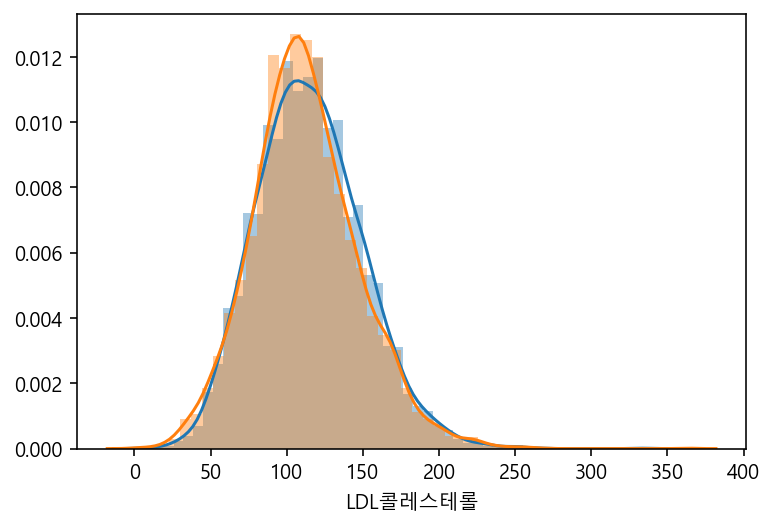

In [15]:
sns.distplot(df.loc[(df["LDL콜레스테롤"].notnull()) & (df["음주여부"] == 0), "LDL콜레스테롤"])
sns.distplot(df.loc[(df["LDL콜레스테롤"].notnull()) & (df["음주여부"] == 1), "LDL콜레스테롤"])

In [20]:
# "LDL콜레스테롤" 의 결측치를 제거한 값에서 중앙값을 구합니다.
ldl_median = df.loc[(df["LDL콜레스테롤"].notnull()), "LDL콜레스테롤"].median() # 밑줄을 제거하고 중앙값을 채워주세요!
ldl_median

111.0

* 아래의 코드를 완성해서 "LDL콜레스테롤"의 결측치를 <font color="blue">중앙값</font>으로 채웁니다.

In [21]:
df["LDL콜레스테롤"] = df["LDL콜레스테롤"].fillna(ldl_median)
df["LDL콜레스테롤"].isnull().sum()

0

#### <font color="blue">TODO 2 Self Review</font>

In [22]:
# LDL콜레스테롤의 결측치가 잘 채워졌는지 다음의 코드를 실행해서 확인합니다.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.check_ldl_median(df)

LDL콜레스테롤의 결측치를 잘 채워주셨습니다. 이어서 진행하셔도 좋습니다.


### <font color="red">TODO 3</font> 결측치 일괄 채우기
*  <font color="blue">replace</font>를 사용해서 전체 결측치를 <font color="red">1</font>로 채웁니다.

In [26]:
df = df.replace(np.nan, 1) # 밑줄을 제거하고 코드를 작성해 주세요!
df.isnull().sum()

기준년도            0
가입자일련번호         0
성별코드            0
연령대코드(5세단위)     0
시도코드            0
신장(5Cm단위)       0
체중(5Kg 단위)      0
허리둘레            0
시력(좌)           0
시력(우)           0
청력(좌)           0
청력(우)           0
수축기혈압           0
이완기혈압           0
식전혈당(공복혈당)      0
총콜레스테롤          0
트리글리세라이드        0
HDL콜레스테롤        0
LDL콜레스테롤        0
혈색소             0
요단백             0
혈청크레아티닌         0
(혈청지오티)AST      0
(혈청지오티)ALT      0
감마지티피           0
흡연상태            0
음주여부            0
구강검진 수검여부       0
치아우식증유무         0
결손치유무           0
치아마모증유무         0
제3대구치(사랑니)이상    0
치석              0
데이터공개일자         0
dtype: int64

#### <font color="blue">TODO 3 Self Review</font>

In [27]:
# 모든 결측치가 잘 채워졌는지 다음의 코드를 실행해서 확인합니다.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.check_null(df)

결측치를 잘 채워주셨습니다. 이어서 진행하셔도 좋습니다.


### 정규분포 형태로 변환
* "총콜레스테롤" 수치의 분포를 그려보면 왼쪽으로 치우쳐서 그려집니다.
* 정규분포를 이루도록 로그변환을 해줍니다.

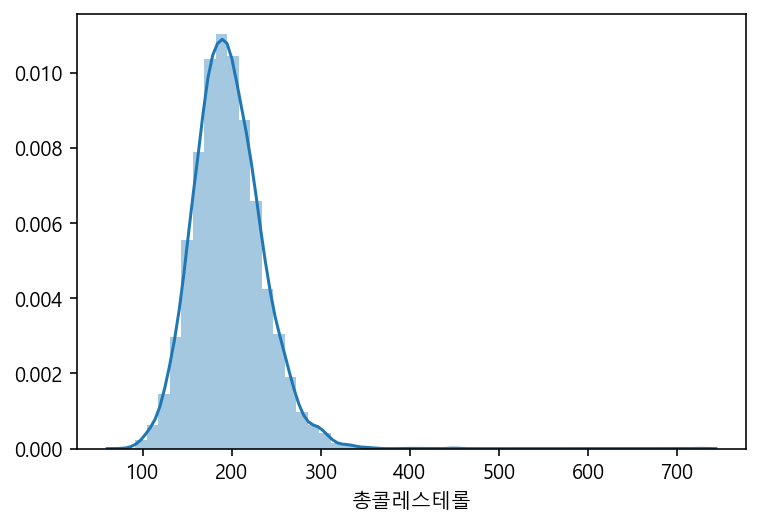

In [28]:
sns.distplot(df["총콜레스테롤"])

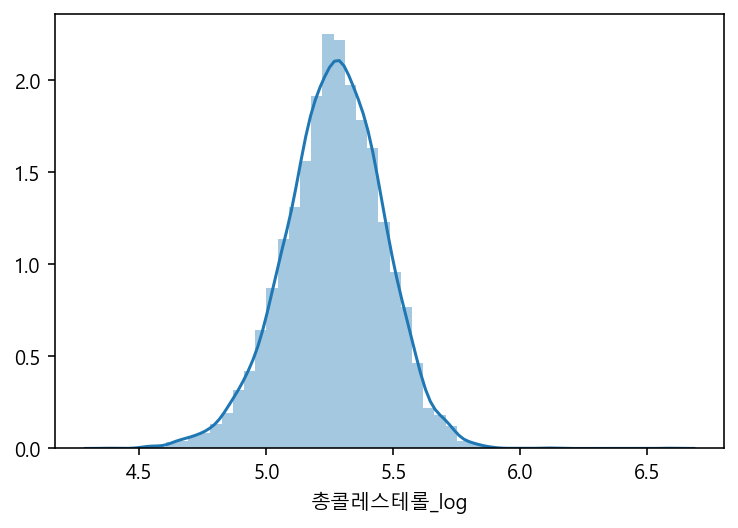

In [29]:
df["총콜레스테롤_log"] = np.log(df["총콜레스테롤"] + 1)
sns.distplot(df["총콜레스테롤_log"])

* "감마지티피"수치의 분포를 그려보면 "총콜레스테롤" 처럼 왼쪽으로 치우쳐서 그려집니다.
* 또한 너무 뾰족한 형태를 이루고 있습니다.
* 정규분포를 이루도록 로그변환을 해줍니다.

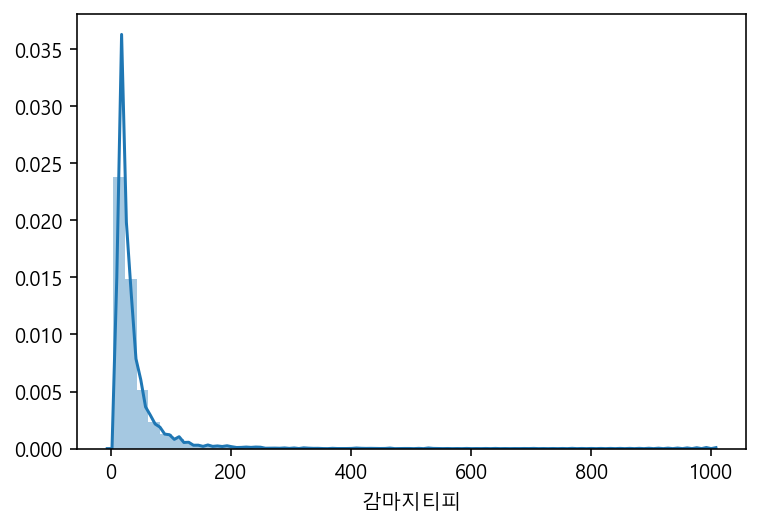

In [30]:
sns.distplot(df["감마지티피"])

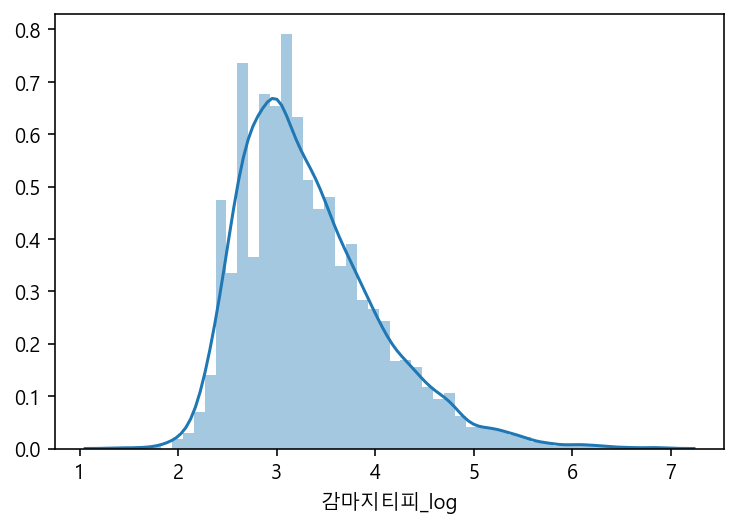

In [31]:
df["감마지티피_log"] = np.log(df["감마지티피"] + 1)
sns.distplot(df["감마지티피_log"])

## 학습, 예측 데이터셋 나누기

### <font color="red">TODO 4</font> 데이터셋 나누기
*  <font color="blue">슬라이싱</font>을 사용해서 학습:예측 데이터를 <font color="red">8:2</font>로 나눕니다.
* train 데이터는 8000개 test 데이터는 2000개의 행을 갖도록 나눕니다.

In [32]:
# 8:2 의 비율로 구하기 위해 전체 데이터의 행에서 80% 위치에 해당되는 값을 구해서 split_count 라는 변수에 담습니다.
split_count = int(df.shape[0] * 0.8)
split_count

8000

In [34]:
# 파이썬의 슬라이싱 기능을 통해 데이터를 나눕니다.
# 위에서 만든 split_count 변수를 사용해서 슬라이싱으로 데이터를 나눠주세요
train = df[:split_count]
test =  df[split_count:]

#### <font color="blue">TODO 4 Self Review</font>

In [35]:
# 셀을 실행해서 데이터셋이 잘 나뉘었는지 확인합니다.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.check_split_dataset(train, test)

train, test 데이터셋을 잘 나누어 주셨습니다. 이어서 진행하셔도 좋습니다.


## 학습, 예측에 사용할 컬럼

In [36]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 가져옵니다.
feature_names = df.columns.to_list()
feature_names

['기준년도',
 '가입자일련번호',
 '성별코드',
 '연령대코드(5세단위)',
 '시도코드',
 '신장(5Cm단위)',
 '체중(5Kg 단위)',
 '허리둘레',
 '시력(좌)',
 '시력(우)',
 '청력(좌)',
 '청력(우)',
 '수축기혈압',
 '이완기혈압',
 '식전혈당(공복혈당)',
 '총콜레스테롤',
 '트리글리세라이드',
 'HDL콜레스테롤',
 'LDL콜레스테롤',
 '혈색소',
 '요단백',
 '혈청크레아티닌',
 '(혈청지오티)AST',
 '(혈청지오티)ALT',
 '감마지티피',
 '흡연상태',
 '음주여부',
 '구강검진 수검여부',
 '치아우식증유무',
 '결손치유무',
 '치아마모증유무',
 '제3대구치(사랑니)이상',
 '치석',
 '데이터공개일자',
 '총콜레스테롤_log',
 '감마지티피_log']

In [37]:
# feature_names 라는 변수에 학습과 예측에 사용할 컬럼명을 따로 가져옵니다.
# 모든 컬럼을 다 사용하지 않습니다. 신호와 소음을 가려냅니다.
feature_names = [
 '성별코드',
 '연령대코드(5세단위)',
 '시도코드',
 '신장(5Cm단위)',
 '체중(5Kg 단위)',
 '허리둘레',
 '시력(좌)',
 '시력(우)',
 '수축기혈압',
 '이완기혈압',
 '식전혈당(공복혈당)',
 '총콜레스테롤_log',
 '트리글리세라이드',
 'HDL콜레스테롤',
 'LDL콜레스테롤',
 '혈색소',
 '요단백',
 '혈청크레아티닌',
 '(혈청지오티)AST',
 '(혈청지오티)ALT',
 '감마지티피_log',
 '흡연상태'
]

## 정답값이자 예측해야 될 값

In [38]:
# label_name 이라는 변수에 예측할 컬럼의 이름을 담습니다.
label_name = "음주여부"
label_name

'음주여부'

## 학습, 예측 데이터셋 만들기

In [39]:
# 학습 세트 만들기 예) 기출문제
X_train = train[feature_names]
print(X_train.shape)
X_train.head()

(8000, 22)


,성별코드,연령대코드(5세단위),시도코드,신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),수축기혈압,이완기혈압,...,트리글리세라이드,HDL콜레스테롤,LDL콜레스테롤,혈색소,요단백,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피_log,흡연상태
0,1,11,41,160.0,70.0,88.0,0.6,0.3,110.0,62.0,...,102.0,39.0,147.0,12.2,4.0,5.0,12.0,11.0,2.708050,2.0
1,1,13,41,165.0,70.0,91.0,0.5,0.6,112.0,67.0,...,156.0,36.0,56.0,14.6,1.0,1.2,28.0,23.0,3.091042,2.0
2,2,8,47,160.0,55.0,73.0,0.9,1.0,104.0,60.0,...,99.0,43.0,103.0,9.9,1.0,0.5,15.0,9.0,2.890372,1.0
3,1,11,41,170.0,70.0,82.0,0.4,0.5,119.0,76.0,...,158.0,49.0,162.0,14.8,1.0,1.0,20.0,16.0,2.890372,1.0
4,1,13,26,155.0,50.0,90.0,1.2,1.2,128.0,84.0,...,243.0,51.0,167.0,15.1,1.0,0.8,44.0,29.0,3.988984,3.0


In [40]:
# 정답 값을 만들어 줍니다. 예) 기출문제의 정답
y_train = train[label_name]
print(y_train.shape)

(8000,)


In [41]:
# 예측에 사용할 데이터세트를 만듭니다. 예) 실전 시험 문제
X_test = test[feature_names]

In [42]:
# 예측의 정답값 예) 실전 시험 문제의 정답
y_test = test[label_name]
print(y_test.shape)

(2000,)


## 머신러닝 알고리즘 사용하기
* [랜덤 포레스트 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8)

### <font color="red">TODO 5</font> 랜덤포레스트 분류기를 만들어 주세요.
* model 이라는 변수에 정의해서 사용합니다.

In [43]:
# 밑줄을 채워 코드를 완성해 주세요.
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=1000,
                               min_samples_split=10, 
                               n_jobs=-1, 
                               random_state=42)
model

RandomForestClassifier(min_samples_split=10, n_estimators=1000, n_jobs=-1,
                       random_state=42)

#### <font color="blue">TODO 5 Self Review</font>

In [44]:
# 분류기가 잘 만들어졌는지 아래의 코드를 실행해서 확인해 주세요.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.valid_model(model)

랜덤포레스트 분류기를 잘 설정해 주셨습니다. 이어서 진행하셔도 좋습니다.


## 학습(훈련)
* 시험을 볼 때 기출문제(X_train)와 정답(y_train)을 보고 공부하는 과정과 유사합니다.

In [45]:
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_split=10, n_estimators=1000, n_jobs=-1,
                       random_state=42)

## 예측
* 실전 시험문제(X_test)라고 보면 됩니다. 우리가 정답을 직접 예측합니다.

In [46]:
y_predict = model.predict(X_test)
y_predict[:5]

array([1., 0., 1., 0., 0.])

## 트리 알고리즘 분석하기
* 피처의 중요도를 시각화 합니다.

In [47]:
# 피처의 중요도를 추출하기
feature_importance = model.feature_importances_
feature_importance

array([0.05995892, 0.07952911, 0.02748438, 0.06401648, 0.03519827,
       0.04373285, 0.02604111, 0.02672176, 0.03892193, 0.03747293,
       0.03956547, 0.04540705, 0.04794834, 0.0568927 , 0.0452742 ,
       0.06322499, 0.00369519, 0.02507006, 0.03729248, 0.04289767,
       0.08826945, 0.06538466])

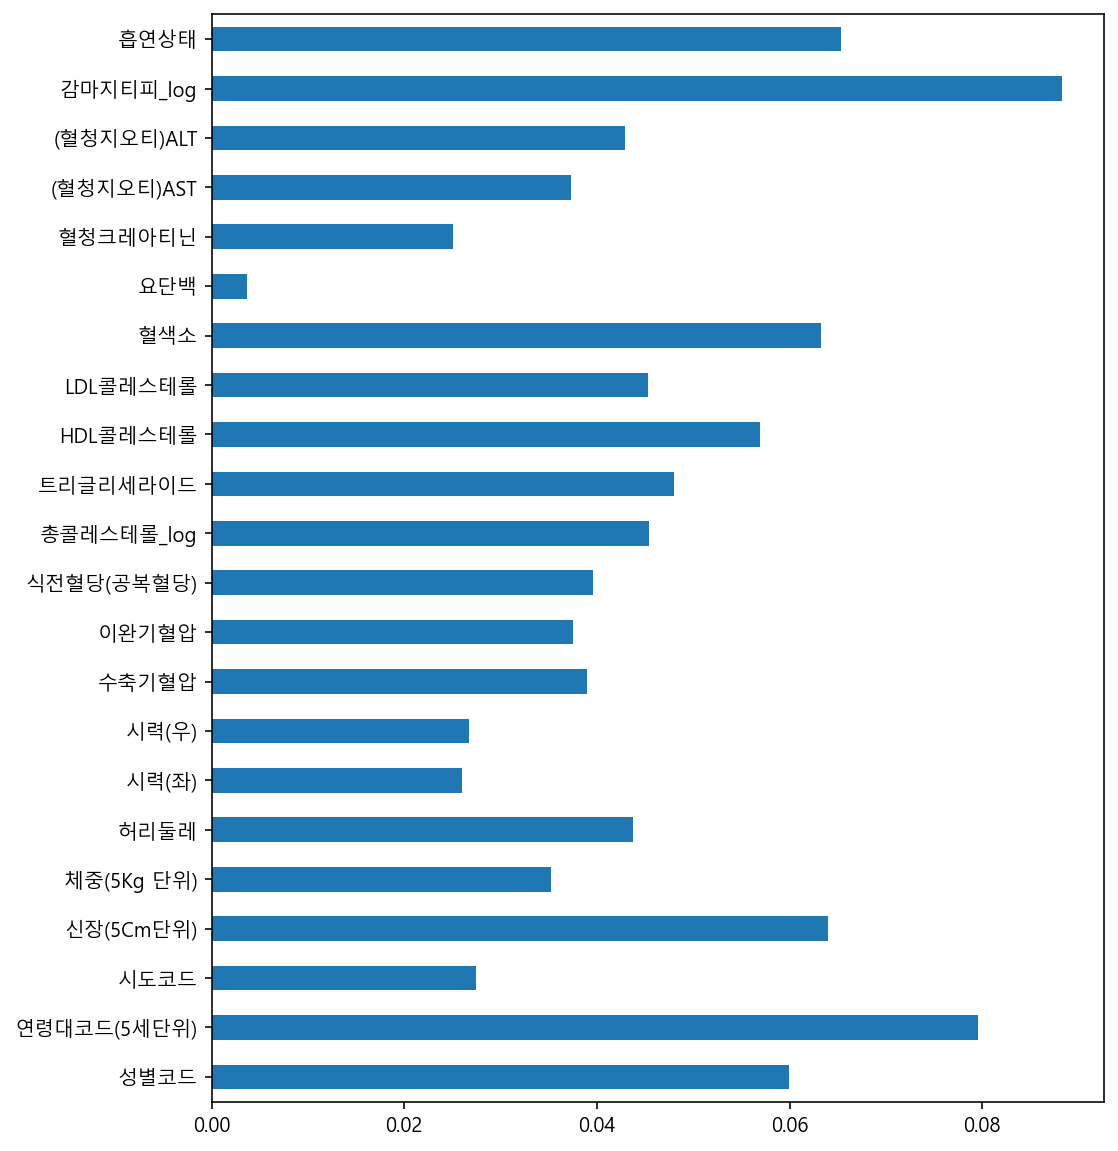

In [48]:
# 피처의 중요도 시각화 하기
pd.Series(feature_importance, index=feature_names).plot.barh(figsize=(8, 10))

## 정확도(Accuracy) 측정하기

In [49]:
# 실제값 - 예측값을 빼주면 같은 값은 0으로 나오게 됩니다. 
# 여기에서 절대값을 씌운 값이 1인 값이 다르게 예측한 값이 됩니다.
# diff_count 에 값을 넣어줍니다.
diff_count = abs(test[label_name] - y_predict).sum()
diff_count

531.0

In [50]:
# 예측의 정확도를 구합니다. 100점 만점 중에 몇 점을 맞았는지 구한다고 보면 됩니다.
((len(y_predict) - diff_count) / len(y_predict)) * 100

73.45

### <font color="red">TODO 6</font> 사이킷런의 Accuracy 로 정확도를 측정해 주세요.
* 사이킷런의 accuracy는 metrics 의 accuracy_score 를 사용해서 구할 수 있습니다.

In [51]:
# 위에서 처럼 직접 구할 수도 있지만 미리 구현된 알고리즘을 가져와 사용합니다.
# 밑줄을 완성해서 accuracy를 측정해 주세요.
from sklearn.metrics import accuracy_score

score = accuracy_score(y_test, y_predict) * 100
score

73.45

#### <font color="blue">TODO 6 Self Review</font>

In [52]:
# 스코어를 체크해 주세요.
# 아래의 코드를 실행해서 확인을 해주어야 제출파일을 작성할 수 있으니 꼭 확인해 주세요!
checker.check_score(score)

모델 성능이 기준치를 넘었습니다! 이어서 진행하셔도 좋습니다.


## 프로젝트 제출 파일 만들기
* 아래의 코드를 실행하기 전에 <font color="red">실습한 주피터 노트북을 저장 버튼을 누르거나 다음의 단축키로 (ctrl/cmd + s) 저장</font>해 주세요. 
* 아래의 코드를 실행해 주세요. 
* 프로젝트 제출 파일이 생성됩니다.
* `제출파일 자동생성`은 주피터 익스텐션이 설치되어 있어야 실행이 가능합니다.
* 주피터 익스텐션은 다음의 방법으로 설치 가능합니다.
* 주피터 노트북의 `홈화면에서 > 오른쪽 상단 > New > Ternimal`로 설치해 주세요.
    * pip install jupyter_contrib_nbextensions
    * conda install jupyter_contrib_nbextensions
* submit 폴더에 다음 두 개의 파일이 생성되어 있어야 제출 파일이 제대로 생성된 것입니다.
    * health-regression-project.html
    * regression_submission.csv
* html 파일이 submit 폴더에 생성되지 않았다면 주피터 노트북의 `메뉴 > File > Download as > HTML(.html)` 을 통해 html 파일을 생성해 주시고 shubmit 폴더에 저장 후 압축해서 제출해 주세요.

In [ ]:
# 아래의 코드를 실행해서 프로젝트가 잘 작성되었는지 확인해 주세요.
# TODO 항목이 잘 구현되었다면 아래의 코드는 submit.zip 파일로 제출파일을 생성합니다.
# TODO 항목을 만족하지 않는다면 구현해야할 목록이 출력됩니다.
# 실행시간이 조금 오래 걸릴 수도 있습니다. 오류가 나지 않는다면 최대 30초 정도 기다려주세요!
checker.check_submit()